In [93]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
from leia import SentimentIntensityAnalyzer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from PortugueseLemmatizer import PortugueseMess
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

nltk.download('vader_lexicon')
nltk.download('rslp')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yonix42\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [94]:
ativos = ["AMER3_3", "MGLU3_3", "PETR4_3"]
dados = []

for ativo in ativos:
    dados.append(pd.read_csv(f"./{ativo}.csv"))

In [95]:

def combinar_paragrafos(texto_lista):
    texto = ' '.join(texto_lista.strip("[]").replace("'", "").split(", "))
    texto = texto.lower()
    return texto

def remove_stop_words(texto):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    retorno = []
    for p in texto:
        if p not in stopwords:
            retorno.append(p)
    return retorno

def remove_pontuacao(texto):
    retorno = []
    for token in texto:
        token = re.sub(r'[^a-zA-Z0-9\s]', '', token)
        token = unicodedata.normalize('NFD', token).encode('ascii', 'ignore').decode('utf-8')
        retorno.append(token)
    retorno = list(filter(None, retorno))
    return retorno

def tokenizacao_lemmatizer(texto):
    tokens = word_tokenize(texto)
    palavras_lemmatizadas = [PortugueseMess(w) for w in tokens]
    return palavras_lemmatizadas

def analisar_sentimento(texto):
    analisador = SentimentIntensityAnalyzer()
    
    if type(texto) == list:
        texto = " ".join(texto)
    return analisador.polarity_scores(texto)['compound'] 

def retornar_sentimento(sentimento):
    if sentimento >= 0.05:
        return 'positivo'
    elif sentimento <= -0.05:
        return 'negativo'
    else:
        return 'neutro'

In [96]:
for dado in dados:
    dado['texto'] = dado['texto'].apply(combinar_paragrafos)
    dado['sent_proc_cru'] = dado['texto'].apply(analisar_sentimento)

    dado['proc_1'] = dado['texto'].apply(tokenizacao_lemmatizer)
    dado['proc_2'] = dado['proc_1'].apply(remove_stop_words)
    dado['proc_3'] = dado['proc_2'].apply(remove_pontuacao)
    dado['sent_proc_3'] = dado['proc_3'].apply(analisar_sentimento)

    dado['sent_cru_texto'] = dado['sent_proc_cru'].apply(retornar_sentimento)
    dado['sent_proc_3_texto'] = dado['sent_proc_3'].apply(retornar_sentimento)

In [97]:
def plotar_analise(df, ativo):
    negativos_pre = df['sent_cru_texto'].tolist().count('negativo')
    neutros_pre = df['sent_cru_texto'].tolist().count('neutro')
    positivos_pre = df['sent_cru_texto'].tolist().count('positivo')

    negativos_pos = df['sent_proc_3_texto'].tolist().count('negativo')
    neutros_pos = df['sent_proc_3_texto'].tolist().count('neutro')
    positivos_pos = df['sent_proc_3_texto'].tolist().count('positivo')

    sentimentos = ['Negativo', 'Neutro', 'Positivo']

    quantidades_pre = [negativos_pre, neutros_pre, positivos_pre]
    quantidades_pos = [negativos_pos, neutros_pos, positivos_pos]

    largura = 0.35

    x = range(len(sentimentos))

    fig, ax = plt.subplots()

    ax.bar([i - largura/2 for i in x], quantidades_pre, largura, label='pré')
    ax.bar([i + largura/2 for i in x], quantidades_pos, largura, label='pós')

    ax.set_xlabel('Sentimento')
    ax.set_ylabel('Quantidade')
    ax.set_title(f'Comparação da analise de sentimentos pré e pós, {ativo}')

    ax.set_xticks(x)
    ax.set_xticklabels(sentimentos)

    ax.legend()

    for i, v1, v2 in zip(x, quantidades_pre, quantidades_pos):
        plt.text(i - largura/2, v1, str(v1), ha='center', va='bottom')
        plt.text(i + largura/2, v2, str(v2), ha='center', va='bottom')

    plt.show()

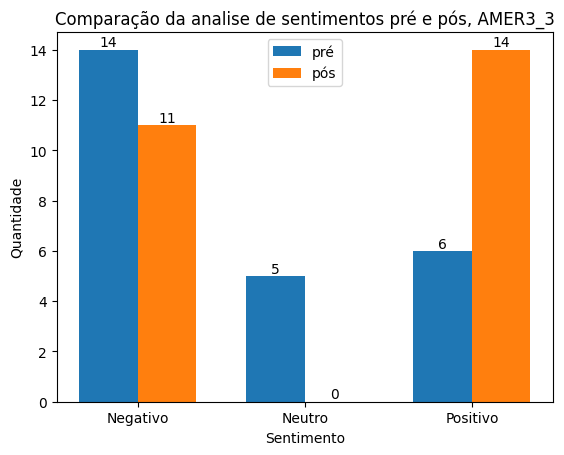

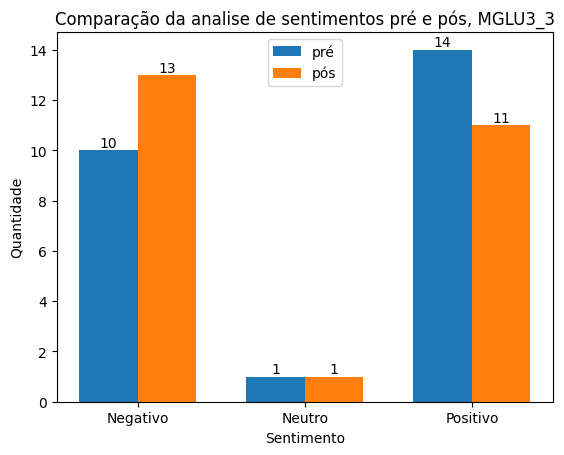

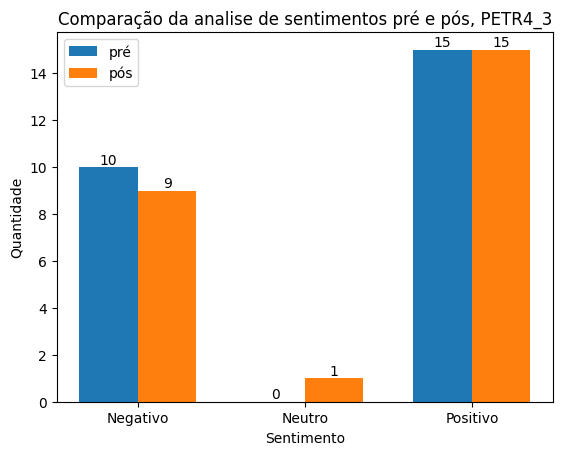

In [98]:
for i, dado in enumerate(dados):
    plotar_analise(dado, ativos[i])

aberturaDiaAnterior fechamentoDiaAnterior


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


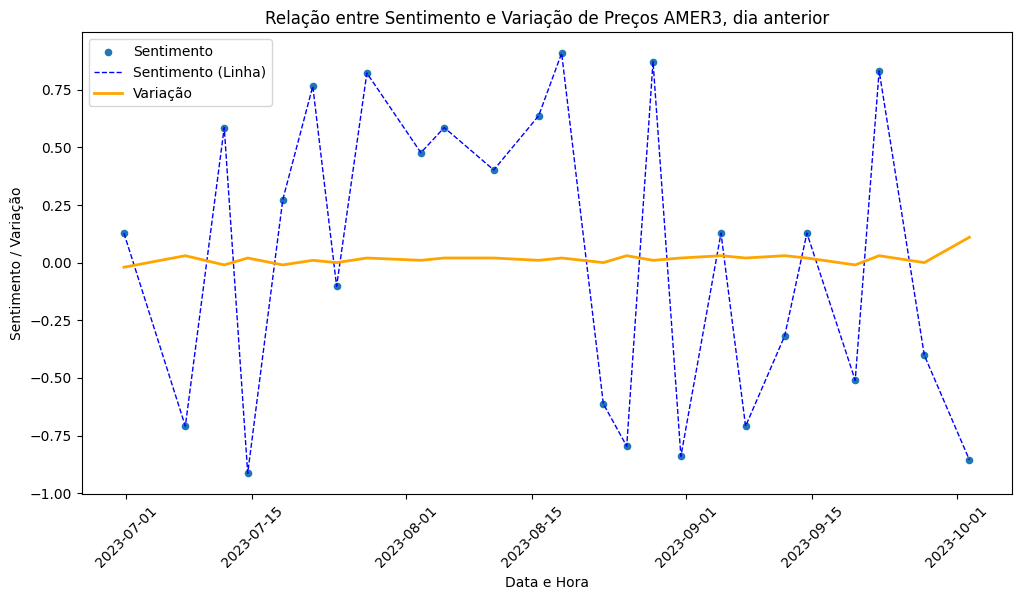

aberturaDiaAtual fechamentoDiaAtual


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


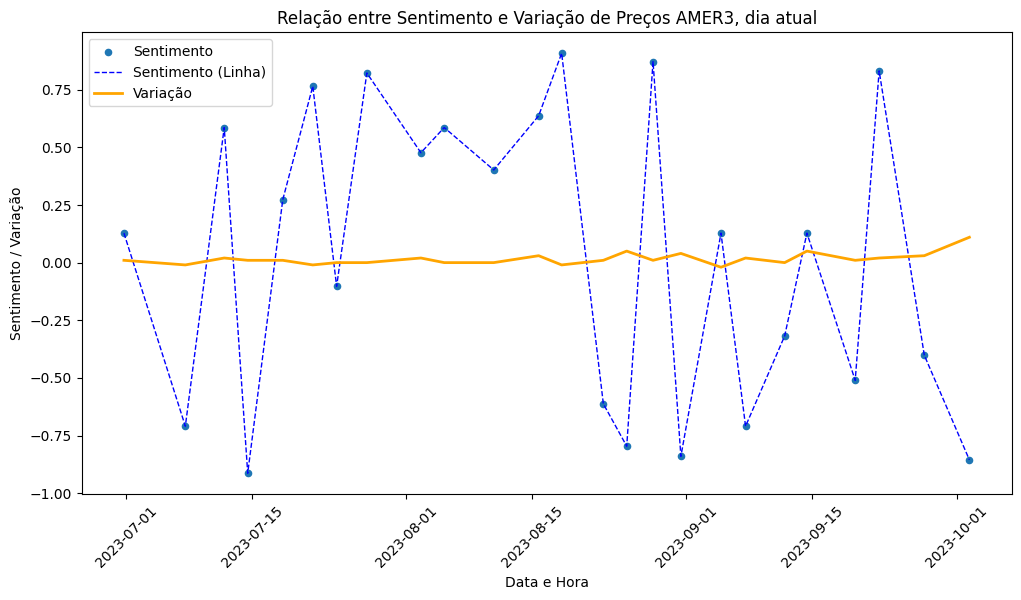

aberturaDiaSeguinte fechamentoDiaSeguinte


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


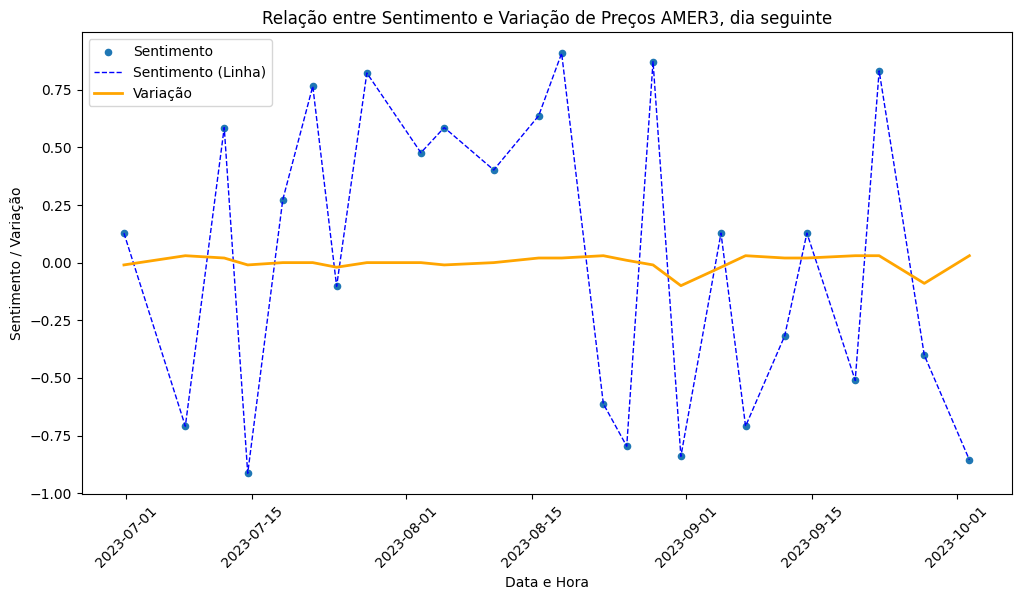

abertura2Dias fechamento2Dias


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


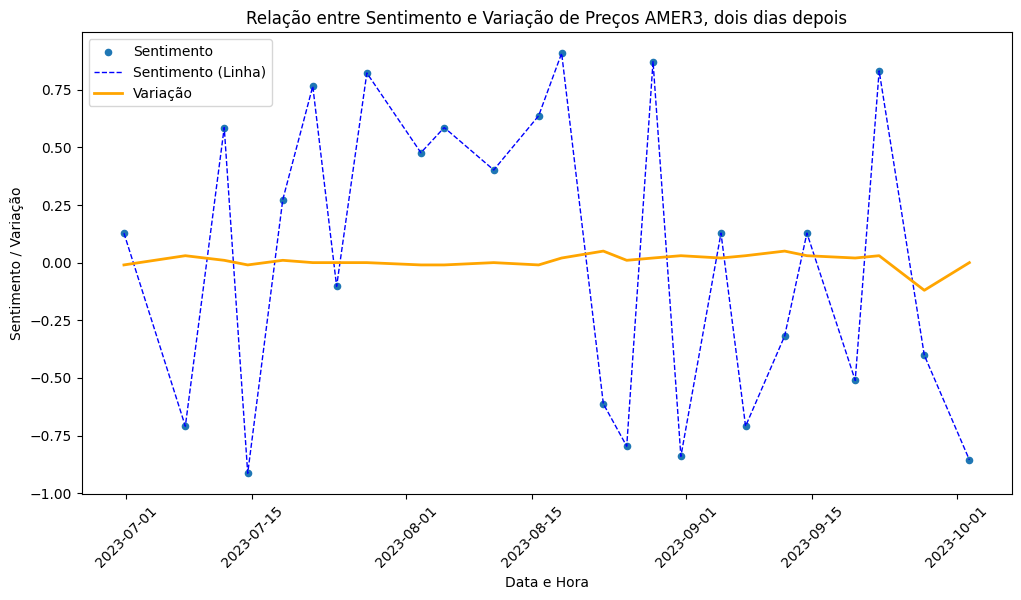

aberturaDiaAnterior fechamentoDiaAnterior


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


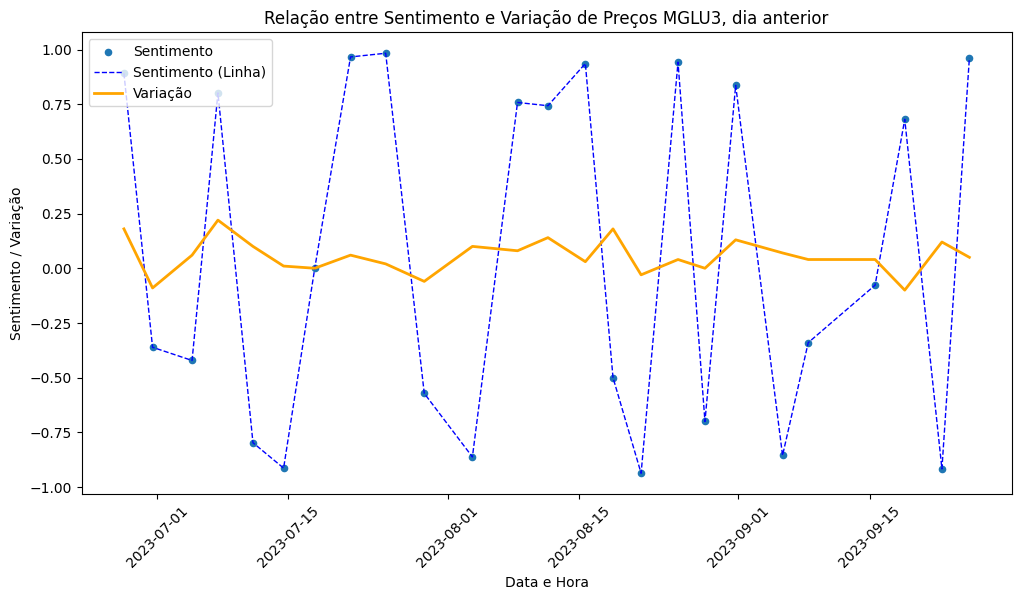

aberturaDiaAtual fechamentoDiaAtual


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


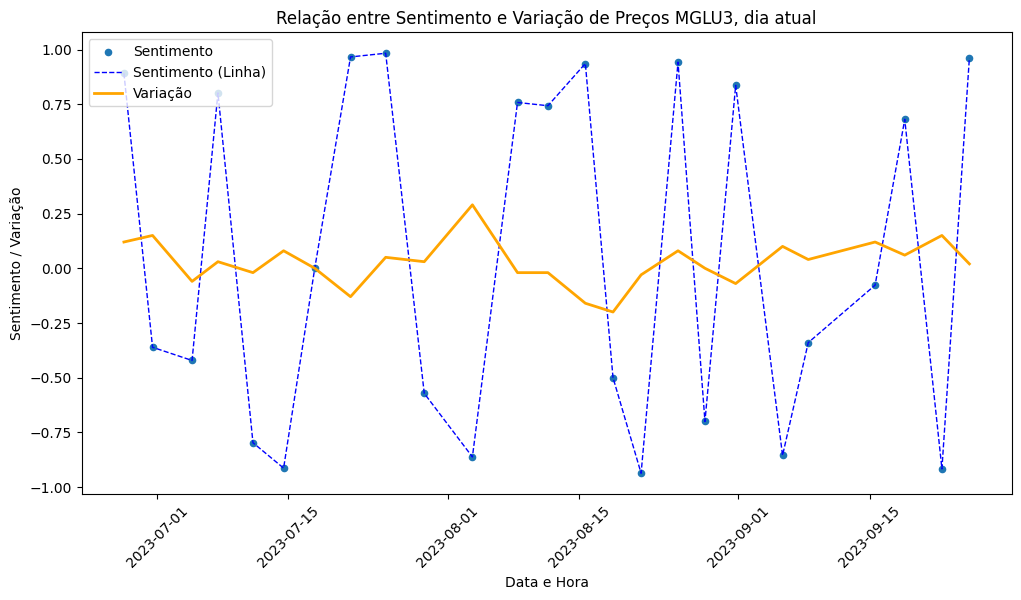

aberturaDiaSeguinte fechamentoDiaSeguinte


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


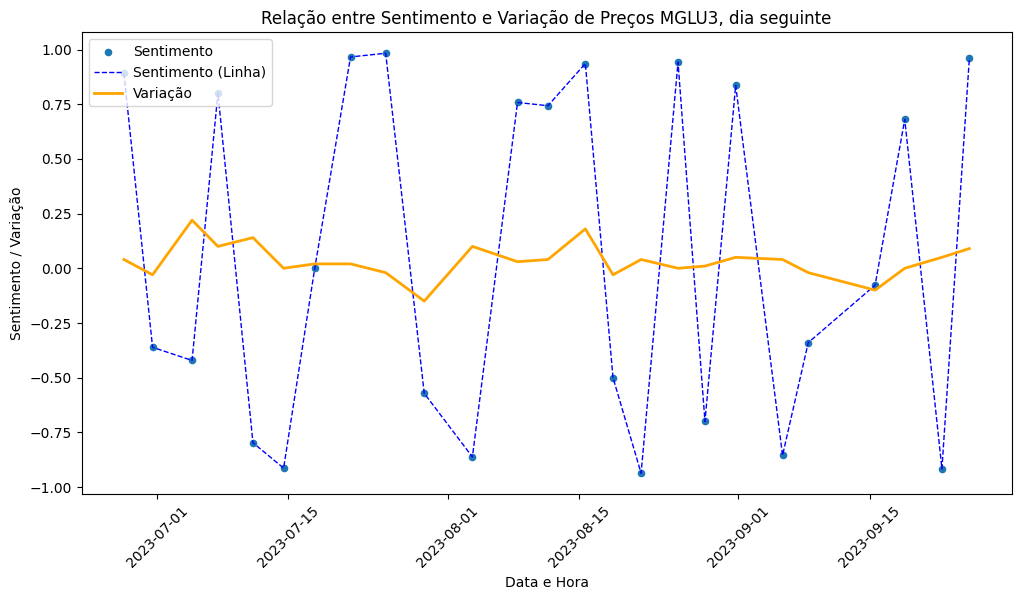

abertura2Dias fechamento2Dias


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


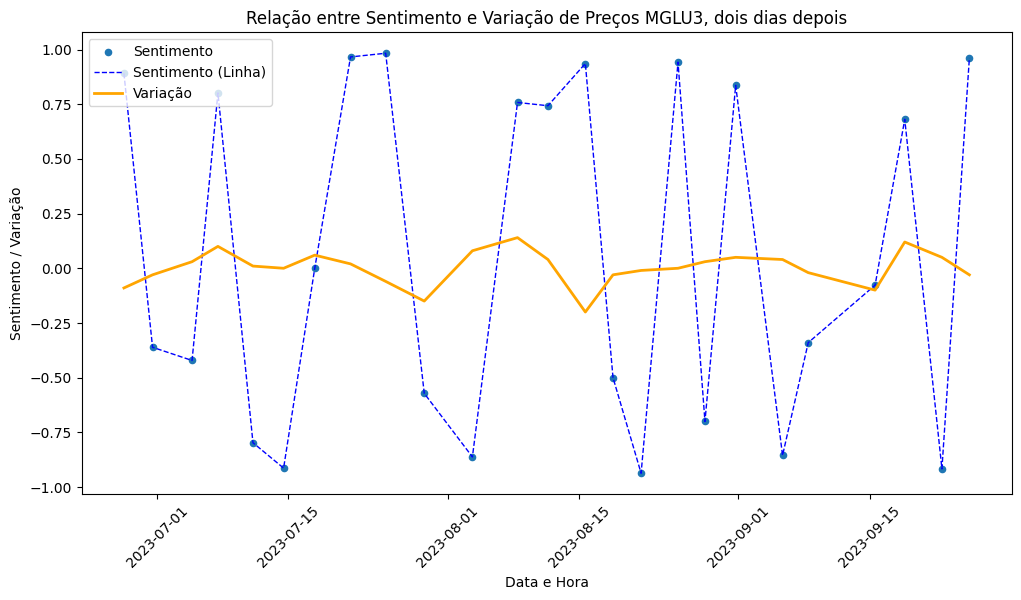

aberturaDiaAnterior fechamentoDiaAnterior


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


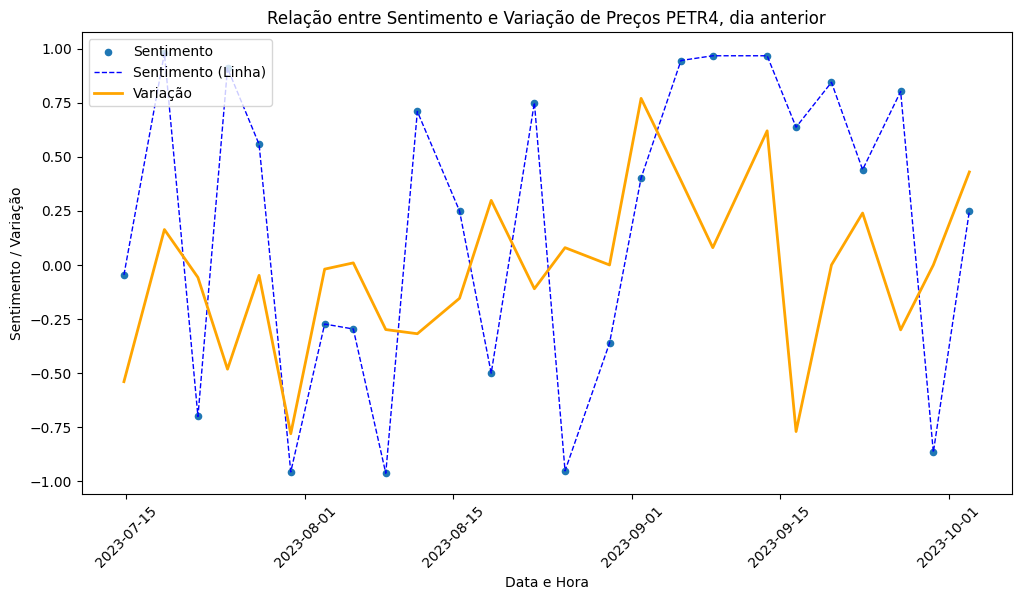

aberturaDiaAtual fechamentoDiaAtual


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


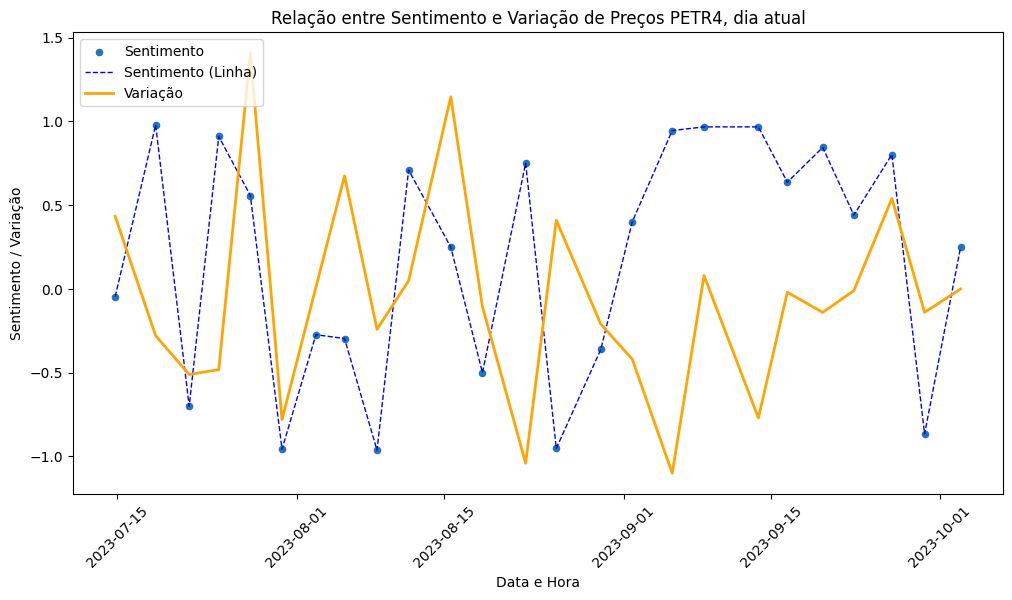

aberturaDiaSeguinte fechamentoDiaSeguinte


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


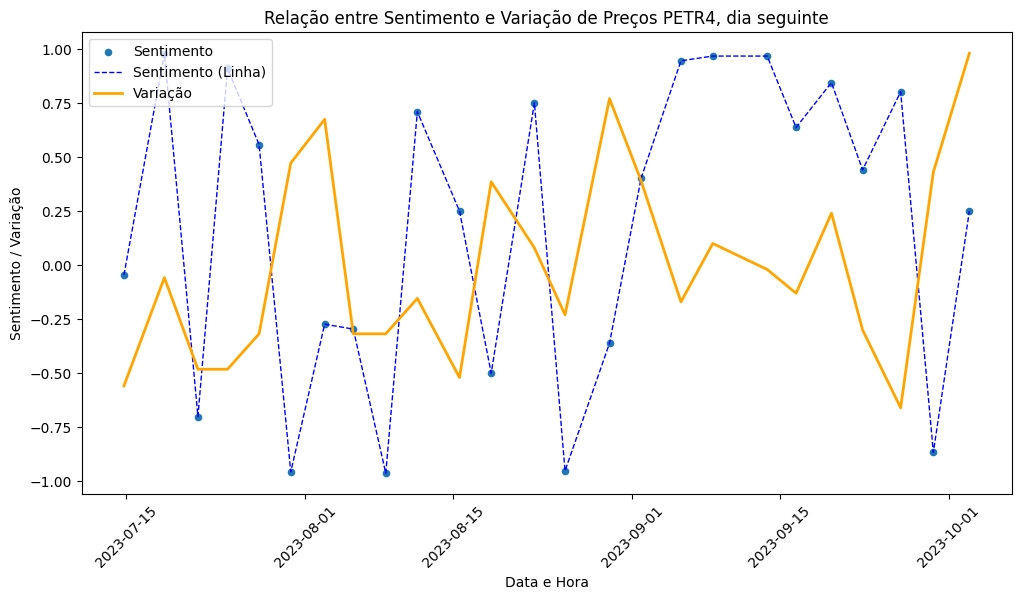

abertura2Dias fechamento2Dias


C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
C:\Users\yonix42\AppData\Local\Temp\ipykernel_10476\1318960922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]


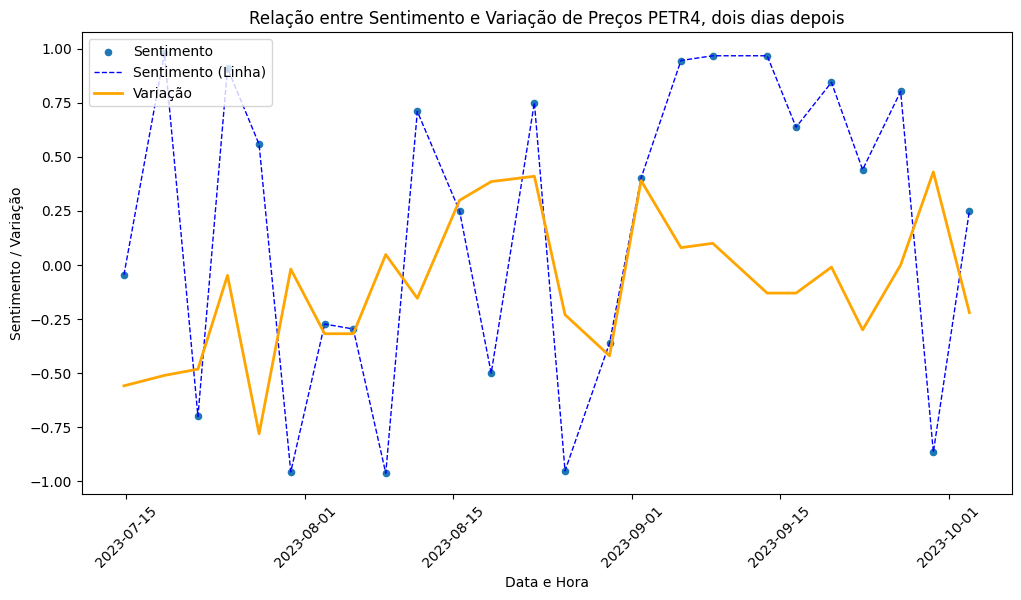

In [105]:
label = [", dia anterior", ", dia atual", ", dia seguinte", ", dois dias depois"]
aberturas = ["aberturaDiaAnterior", "aberturaDiaAtual", "aberturaDiaSeguinte", "abertura2Dias"]
fechamentos = ["fechamentoDiaAnterior", "fechamentoDiaAtual", "fechamentoDiaSeguinte", "fechamento2Dias"]
for i, dado in enumerate(dados):
    for j in range(len(aberturas)):
        abertura = aberturas[j]
        fechamento = fechamentos[j]
        print(abertura, fechamento)

        dados_analise = dado[['data_hora', 'sent_proc_3', abertura, fechamento]]

        # Converta a coluna 'data_hora' para o tipo datetime, se já não estiver
        dados_analise['data_hora'] = pd.to_datetime(dados_analise['data_hora'])
        dados_analise['variacao'] = dados_analise[abertura] - dados_analise[fechamento]

        plt.figure(figsize=(12, 6))

        # Plote os pontos usando 'sent_proc_3' como coordenada y
        plt.scatter(dados_analise['data_hora'], dados_analise['sent_proc_3'], label='Sentimento', s=20)

        # Plote uma linha pontilhada azul ligando os valores de 'sent_proc_3'
        plt.plot(dados_analise['data_hora'], dados_analise['sent_proc_3'], c='blue', linestyle='--', label='Sentimento (Linha)', linewidth=1)

        # Plote a variação no eixo y
        plt.plot(dados_analise['data_hora'], dados_analise['variacao'], c='orange', label='Variação', linewidth=2)

        plt.xlabel('Data e Hora')
        plt.ylabel('Sentimento / Variação')
        nome = ativos[i].split("_")
        plt.title(f'Relação entre Sentimento e Variação de Preços {nome[0]}{label[j]}')

        plt.xticks(rotation=45)
        plt.legend(loc='upper left')

        plt.show()